In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
from sklearn.decomposition import KernelPCA
import os
from sklearn.manifold import TSNE
from PIL import Image
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import hdbscan
from collections import Counter
from tempfile import TemporaryDirectory
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import seaborn as sns
cudnn.benchmark = True
plt.ion()   # interactive mode

Q1 ResNet -18 has a already a pretrained model trained on a large dataset which can be used for fixed
feature extraction via transfer learning as demonstrated in https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
We just need to freeze weights in all but last layer (disable back propogation) and finaaly train output layer to extract various features on input images


In [2]:
## visulaize and preprocess data downloaded from the site
# sequence of transformation to be applied as mentioned in example code snippets of transfer learning
##since we might need training and validation datasets lets deform transformations as dictionary as done in examples
preprocess = { 
    "train" : transforms.Compose([
    transforms.Resize(256),
    ##centre cropping to extract most relevant part
    transforms.CenterCrop(224),
    ##convert from np to pytorch tensors
    transforms.ToTensor(),
    ##normalize (common scale stablizes training)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]),
    "val" : transforms.Compose([
    transforms.Resize(256),
    ##centre cropping to extract most relevant part
    transforms.CenterCrop(224),
    ##convert from np to pytorch tensors
    transforms.ToTensor(),
    ##normalize (common scale stablizes training)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
}              
##load dataset  
datasets = {x: datasets.ImageFolder(os.path.join("hymenoptera_data", x),
                                          preprocess[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
###i am using cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

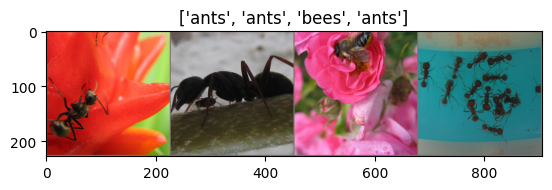

In [3]:
## to visulaize some images directly used imshow defined in transfer learning web
def imshow(inp, title=None):
    ##some basic processing before display
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) ##normalize in 0 to 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[datasets['train'].classes[x] for x in classes])

In [4]:
def Extract_features(dataloaders, display=True):
    # Load pretrained ResNet18
    model = models.resnet18(pretrained=True)
   ##refchatgpt  this uses Resnet18 as feature extractor
   ##by removing output prediction layer we are essentially extracting features
    model.fc = torch.nn.Identity()  
    
    # Store extracted features and labels
    Features = []
    Labels = []
    
    # Put the model in evaluation mode
    model.eval() 
   
    with torch.no_grad(): #no grad computation needed
        for inputs, labels in dataloaders:  # Iterate over datasets (labeled images)
            features = model(inputs)  # Extract features for an image
            Features.append(features.numpy())  # Add features to list
            Labels.append(labels.numpy())  # Add labels to list
            
    if display:
        print(f"Following features are extracted using ResNet18: {Features}")
    
    ##convert list to a single 2d numpy array
    return np.concatenate(Features)


features = Extract_features(dataloaders["train"], False)


/home/prachit/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/prachit/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1b) K means is an unsupervised clustering method in which we initialize random clusters with random centroids => assign datapoints to clusters based on euclidian distance from centroid => update centroids to mean of assigned datapoints => repeat till point of convergence

having this basic notion of algorithm , i am using an exsisting Kmeans class defined in scikit-learn
ref :https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

/home/prachit/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/prachit/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/prachit/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/prachit/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

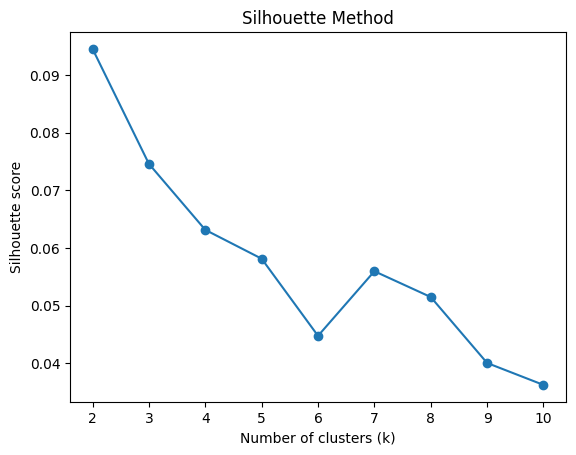

Best number of clusters (k): 2


In [5]:
# Train k-means Based on silhoutes scores (-1: bad 0:boundary and 1:good)
silhouette_scores = [] ##store scores
for k in range(2, 11):  # vary no of clusters from 2 to n
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    ##ref chat gpt : calculate scores
    silhouette_avg = silhouette_score(features, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
##best k stored in index of max score
k_best = np.argmax(silhouette_scores) + 2  ##add 2 to get back into original range
# Visualize silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()

print("Best number of clusters (k):", k_best)


/home/prachit/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


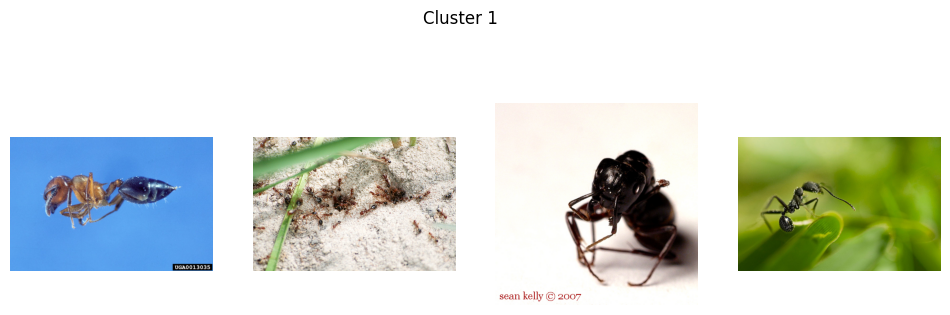

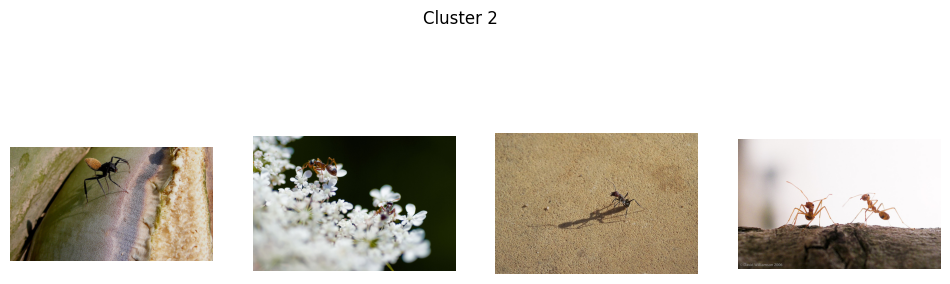

In [6]:
# visulaize clusters
kmeans = KMeans(n_clusters=k_best) ##use best cluster no.
kmeans.fit(features) ##fit

##ref chat gpt  modified to fit our data
# Visualize a few samples in each cluster
for cluster_idx in range(k_best):
    cluster_samples_index = np.where(kmeans.labels_ == cluster_idx)[0] ##identify index where image label matches cluster idx(i.e image belongs to cluster) 
    #sample_indices = np.random.choice(cluster_samples_index, 4, replace=False) ##randomly select 4 image indices per cluster
    sample_indices = cluster_samples_index[0:4]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(f'Cluster {cluster_idx + 1}') ##give title idx 0 = cluster 1
    
    for i, idx in enumerate(sample_indices):
        img_path = datasets["train"].imgs[idx][0] ##path of image in given indices
        img = plt.imread(img_path)

        axes[i].imshow(img)
        axes[i].axis('off')
    
    plt.show()

Observation = clearly clusters have mix of both ants and bees which was expected as the best score itself was around 0.1 i.e barely on decesion boundary

1d) ref : https://towardsdatascience.com/evaluation-metrics-for-clustering-models-5dde821dd6cd
to analyse cluster purity we first assign a label to each cluster based on the most frequent class in it => purity => the number of correctly matched class and cluster labels / the number of total data images lets code this notion out

In [7]:
##class to bool 
classToLabel = [0,1]

# ##psedo code iterate over each image label in trained kmean , for all images belonging to a cluster
##compare with ground truth if ant or bee and add all bool values to get their no.s
##coded this with gpt
def assign_cluster_labels(cluster_labels): ##assign cluster labels 0 if majority is ant and 1 if majority is bee
    unique_clusters = set(cluster_labels)##divide in cluster indices
    cluster_mapping = {} ##dic to store maping of cluster idx to lael(ant or bee)
    cluster_true_labels = {} ##dic to store true values of cluster
    for cluster in unique_clusters: ##iterate over cluster
        cluster_indices = [i for i, x in enumerate(cluster_labels) if x == cluster] ##indices of image belonging to a given cluster
        ##calculate ground truth labels of corresponding indices
        true = []
        for idx in cluster_indices:
            _, classes = dataloaders["train"].dataset[idx]
            true.append(classToLabel[classes]) ##append actual label of image to true
        cluster_true_labels[cluster] = true
        majority_class = Counter(cluster_true_labels).most_common(1)[0][0] ##use counter ref : gpt to find majority class
        cluster_mapping[cluster] = majority_class ##assign majority class to acluster (0: ants or 1 : bees based onmajority)
        
    return cluster_true_labels, cluster_mapping

def calculate_cluster_purity(cluster_mapping,cluster_idx, true_labels): ##return purity as no. of correctly matched images with cluster assignment/ total
    total_samples = len(true_labels) ##total samples in a given cluster
    correct_predictions = 0 
    majority_class = cluster_mapping[cluster_idx] ##majority class of cluster
    for true_label in true_labels:
        if majority_class == true_label: ##iterate over each img check if majority class = actual labe;
            correct_predictions += 1 ##count correct predictions(matches)
    purity = correct_predictions / total_samples
    return purity

true_labels, cluster_mapping = assign_cluster_labels(kmeans.labels_) ##dictionaries having true values and majority class of clusters

purity = {} ##stores purity of both custers
# Calculate Cluster Purity
for cluster_idx in range(k_best):
    purity[cluster_idx] = calculate_cluster_purity(cluster_mapping,cluster_idx, true_labels[cluster_idx])
    

##display
for i in range(k_best):
    print(f"Cluster Purity of custer {i+1} with majority  class {cluster_mapping[i]} is {purity[i]}")


Cluster Purity of custer 1 with majority  class 0 is 0.45081967213114754
Cluster Purity of custer 2 with majority  class 0 is 0.5573770491803278


1 e) DBSCAN basically identifies certain datapoints(for us features of input images) as core points and expand clusters around them by adding certain neighbourhood points using notion of euclidian distances via hyperparameter ep which define the radius of circle under consideration for expanding clusters. Core points are high density points within clusters that have atleast threshold no. of datapoints within epsilon distance(specified using another hyperparam = min_Samples)
.Clusters are expanded by adding neighbourhood points which is explored recursively until no more points can be added to the cluster.
ref : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
directly using predefined module DBscan for the same

In [8]:
# varying hyperparameters to slect optimal no. of clusters
min_samples_range = range(4, 10)
eps_range = [0.1, 0.5, 1.0, 1.5, 2.0]

best_silhouette_score = -1 ##best score is 1 (too be updated)
best_params = {}
silhouette_scores = []

# Train DBSCAN
def train_dbscan(features, eps, min_samples):
    # Initialize DBSCAN module as given in docs
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # Fit DBSCAN to the features
    dbscan.fit(features)
    return dbscan

for min_samples in min_samples_range:
    for eps in eps_range:  ##iterate over all hyperparameters
        dbscan = train_dbscan(features, eps, min_samples) ##fit model
        #print( len(np.unique(dbscan.labels_)))
        if len(np.unique(dbscan.labels_)) > 1: ##more thatn 1 cluster needed for score computation
            # Calculate silhouette score
           
            silhouette = silhouette_score(features, dbscan.labels_)
            silhouette_scores.append(silhouette) ##store for plotting
            # determine best parameters based on scores
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_params = {'eps': eps, 'min_samples': min_samples} ##dic containing best params

print(best_params)

"""commented as getting null values"""
# ##optimal model based on best param
# best_dbscan = DBSCAN(eps=best_params["eps"], min_samples=best_params["min_samples"], algorithm='ball_tree', metric='minkowski', leaf_size=90, p=2)
# best_dbscan.fit(features)

# # Determine corresponding optimal number of clusters
# best_clusters = len(np.unique(best_dbscan.labels_))
# print("Best Parameters:", best_params)
# print("Number of Clusters:", best_clusters)


{}


'commented as getting null values'

Observation : irrespective of values of hyperparameters passed, DBSCAN is unable to form more that 1 cluster, an issue quite common faced by other people as well (some stackexchange threads). 
DBSCAN based on density sparsity so to form clusters it requires high density cluster separated by several low density data points which is quite difficult to find if data is not appropriate
Also its highly sensitive to hyperparameters so lets fit the model after scaling features and see if that stablizes data for training

In [9]:
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Now apply DBSCAN on the scaled features
dbscan = DBSCAN(eps=50, min_samples=1000)  # large eps and large no of samples to tackle low density data
dbscan.fit(scaled_features)
#print(dbscan.labels_)
clusters = len(np.unique(dbscan.labels_))
print("Number of Clusters:", clusters)

Number of Clusters: 1


On finding no improvement in the model predictions of clusters and by trying several hyperparameters, I decided to shift to hdbscan
ref : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html
It basically automatically determines the number of clusters and handles varying densities through its hierarchical approach and its built upon dbscan to be more robust to params. It uses same density sparsity based approach for cluster formation but has the ability to construct a hierarchical cluster tree and select the most stable clusters, something which also takes care of noise points much more effectively than dbscan


In [10]:
# Instantiate the HDBSCAN model with suitable parameters 
hdbscan_model = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5)

# Fit the model to extracted features
hdbscan_model.fit(features)
##get labels
labels = hdbscan_model.labels_
# Get the number of clusters (-1 indicates noise points)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters:", num_clusters)

"""-1 corresponds to noisy datapoint grouped as seperate cluster"""


Number of clusters: 2


'-1 corresponds to noisy datapoint grouped as seperate cluster'

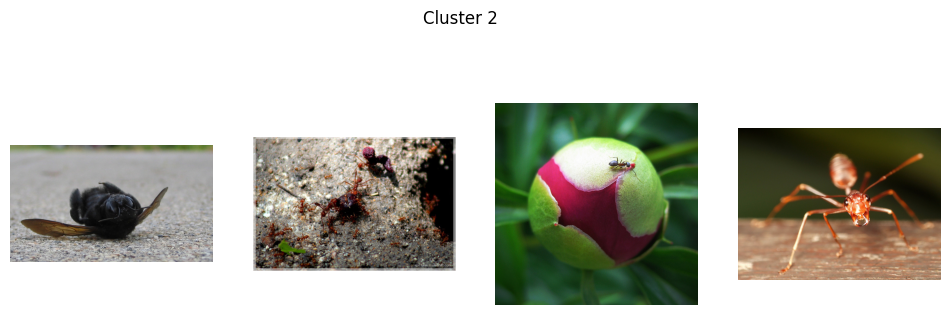

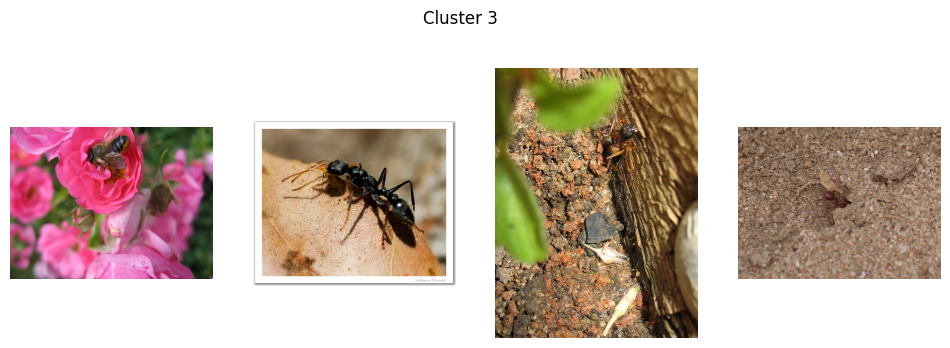

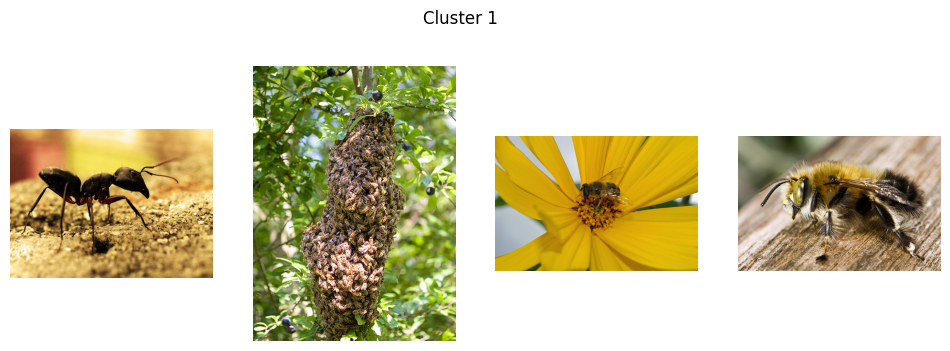

In [11]:
## 1g
clusterToidx = {-1 : 1, 0 : 2, 1 : 3} ##convert cluster no to its index [-1 : 0 , 0: 1 , 1: 2]

for cluster in set(labels):
    cluster_samples_index = np.where(labels == cluster)[0] ##identify index where image label  matches cluster label(i.e image belongs to cluster) 
    sample_indices = np.random.choice(cluster_samples_index, 4, replace=False) ##randomly select 4 image indices per cluster
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    ##generate index from cluster
    idx = clusterToidx[cluster]
    fig.suptitle(f'Cluster {idx}') ##give title idx 
    
    for i, idx in enumerate(sample_indices):
        img_path = datasets["train"].imgs[idx][0] ##path of image in given indices
        img = plt.imread(img_path)

        axes[i].imshow(img)
        axes[i].axis('off')
    
    plt.show()
    
    """ cluster 1 corresponds to noise points """

observation:  as clearly seen in plots we get 3 clusters instead of 2 which shows that it can identify arbitry no. of clusters with varied shape and size in contrast to kmeans where i specified that there must be 2 clusters
It seems like each cluster predominately contains bees which is class 1 but purity analysis later suggests that majority class is supposed to be ants for each cluster and purity scores are also pretty low
Also metrics like silhoutte (-0.08) suggest most data points being either close to decesion boundary or are even classified as noise in hdbscan , printing labels also suggested a large no . of noisy datapoints

so for our case kmeans is a better clustering option but i feel that owing to density sparsity approach and cluster formation of arbitary shapes and no. should have made dbscan preferred method (maybe its lack of pre processing in data, presence of many outliers and stuff)

1 f) ref : chat gpt  for hdbscan unlike kmeans there exsists several metrics for quality analysis
the one i used here is the Davies-Bouldin Index (DBI)
broadly measures the average similarity between each cluster and its most similar cluster, taking into account both the intra-cluster and inter-cluster distances. The lower the DBI value, the better the clustering.

to execute it i referred https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
basically it computes the ratio of the average intra-cluster distance to the centroid distance for each cluster and takes the maximum value across all clusters.

In [12]:
silhouette = silhouette_score(features, labels)

db_index = davies_bouldin_score(features, labels)

print(f"silhouette score = {silhouette} and davies bouldin index = {db_index}")
    

silhouette score = -0.08686599135398865 and davies bouldin index = 3.3312171502315073


High dbi indicates small intra cluster distance or large inter cluster distance both of which indicate bad quality clustering

In [13]:
## 1 h  used same algorithm and direclty used function defined for kmeans
true_labels, cluster_mapping = assign_cluster_labels(hdbscan_model.labels_) ##dictionaries having true values and majority class of clusters

purity = {} ##stores purity of all custers
# Calculate Cluster Purity
for cluster_idx in set(hdbscan_model.labels_):
    purity[cluster_idx] = calculate_cluster_purity(cluster_mapping,cluster_idx, true_labels[cluster_idx])
    

##display
clusterToidx = {-1 : 1, 0 : 2, 1 : 3}
for cl in set(hdbscan_model.labels_):
    print(f"Cluster Purity of cluster {clusterToidx[cl]} with majority class {cluster_mapping[cl]} is {purity[cl]}")


Cluster Purity of cluster 2 with majority class 0 is 0.5384615384615384
Cluster Purity of cluster 3 with majority class 0 is 0.5625
Cluster Purity of cluster 1 with majority class 0 is 0.49767441860465117


purity clearly indicates mix of both

1 i) using TNSE we basically reduced the dimensionality of the feature space to two dimensions while preserving the local structure of the data, The plot allows us to visually assess the separation between different clusters.

to implement it i referred : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

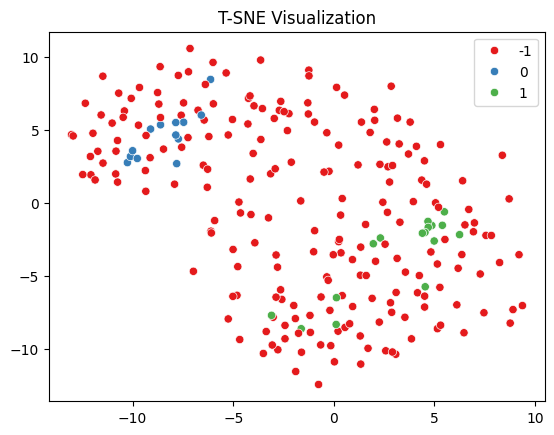

In [14]:
def visualize_tsne(features, cluster_labels):
    tsne = TSNE(n_components=2) ##initialize tnse to reduce dimension to 2d
    tsne_features = tsne.fit_transform(features)##fitted model on features
    sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=cluster_labels, palette='Set1', legend='full') ##scatterd plot
    plt.title('T-SNE Visualization')
    plt.show()

visualize_tsne(features,  labels)

comments : there are a large no. of outliers or noise points perhaps thats why dbscaan failed repeatedely
ignoring red outliears , we can clearly see the 2 clusters locally confined around high density points and seperated by some distance
but overall because of so much noisy points various metrics like DBI give unpromising values

Q2 ) PCA ref : https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=Explained%20variance%20can%20also%20be,better%20at%20representing%20the%20data.

Basically its a dimensionality reduction technique used to simplify the complexity of high-dimensional data while retaining most of its important information. We first transfer the features into orthogonal vectors along which theres most varition of data. THese uncorrelated orthogonal features are called principle components , first few components capture the maximum amount of variance in the data.

implementation referrence : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

basically we compute covariance matrix which measures the pairwise relationships between the different features
then perform its eigen value decomposition and then obtain principle components as eigenvectors of the covariance matrix.

Already predefined functionality , dirctly used



In [15]:
# Fit PCA on the extracted features
pca = PCA()
##model fits to data as well as transforms it to principal component space
pca.fit_transform(features)

array([[ 4.16882467e+00, -1.27537644e+00, -3.43963337e+00, ...,
        -1.79682910e-01,  2.08269104e-01,  3.49378502e-06],
       [ 6.66154289e+00, -4.50937366e+00, -2.65963912e+00, ...,
         7.87289590e-02, -1.17570266e-01,  3.49382572e-06],
       [-7.12694407e+00,  4.78376198e+00, -1.28666818e+00, ...,
         7.22270906e-02, -5.29460656e-03,  3.49385573e-06],
       ...,
       [ 8.51904678e+00, -1.11735916e+00, -4.65026051e-01, ...,
         5.87648265e-02,  4.53397073e-03,  3.49384845e-06],
       [ 3.92266130e+00, -6.51849210e-01,  7.67881215e-01, ...,
         2.10121989e-01, -1.15627144e-02,  3.49374363e-06],
       [ 8.99308503e-01,  6.56013823e+00, -3.45626664e+00, ...,
         2.12563261e-01,  1.33584276e-01,  3.49383140e-06]], dtype=float32)

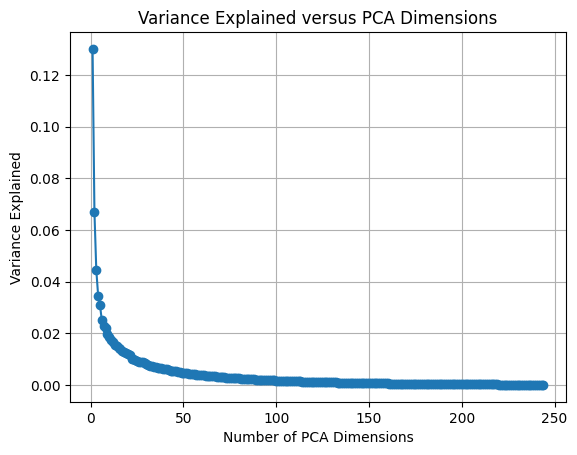

In [21]:
# Plot variance explained versus PCA dimensions
##explained variance ratio measures the amount of variation along a principle component
evr = pca.explained_variance_ratio_
plt.plot(range(1, len(evr) + 1), evr, marker='o')
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('Variance Explained')
plt.title('Variance Explained versus PCA Dimensions')
plt.grid(True)
plt.show()

comments : as expected maximun explained variance ratio is seeen in first 4 principal components,which explain maximum data

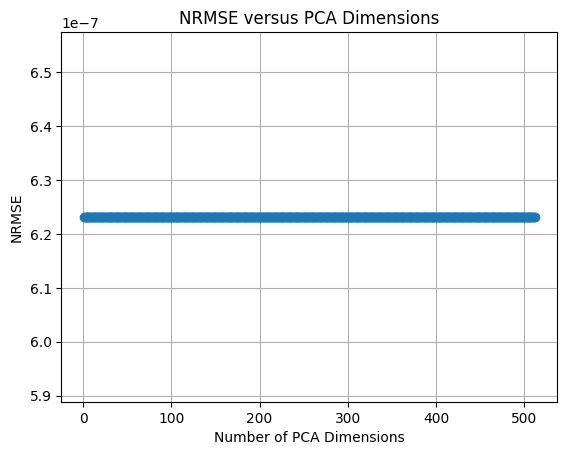

In [23]:
## 2 c
# reconstruct data with specified number of PCA dimensions
##ref chat gpt sytax for  X_reconstructed = pca.inverse_transform(pca.transform(X)) and nrmse = rmse / np.sqrt(np.mean(np.square(original_data)))
def reconstruct_data(pca, X, n_components):
    pca.n_components = n_components ##no. of principal components
    X_reconstructed = pca.inverse_transform(pca.transform(X)) ##transform original data to reduced pca space and then the inverse transformation to reconstruct 
    return X_reconstructed

# compute Normalized Root Mean Squared Error (NRMSE)
def compute_nrmse(original_data, reconstructed_data):
    mse = mean_squared_error(original_data, reconstructed_data) ##deviation from original data
    rmse = np.sqrt(mse)##rms
    nrmse = rmse / np.sqrt(np.mean(np.square(original_data)))## normalize rms
    return nrmse

nrmse_values = [] ##store nmrse value
for n_components in range(1, len(features[0]) + 1): ##iterate over various no of principal components
    # Reconstruct data
    reconstructed_data = reconstruct_data(pca, features, n_components)
    # Compute NRMSE
    nrmse = compute_nrmse(features, reconstructed_data)
    nrmse_values.append(nrmse)

# visulaize
plt.plot(range(1, len(features[0]) + 1), nrmse_values, marker='o') ##len(featuresM[0]) + 1) is no of pca dimensions over which we calculated rms
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('NRMSE')
plt.title('NRMSE versus PCA Dimensions')
plt.grid(True)
plt.show()

Q3)KPCA is an extension of pca capable of capturing nonlinear relationships between data points. It builds over pca but uses non linear mapping to map the original data into a higher-dimensional feature space using a nonlinear function called a kernel function.
then we centre the datapoints to 0 mean to ensure that the resulting principal components capture the directions of maximum variance in the feature space. After this is done we can perform eigen value decomposition and hence principal components and then reduce dimensions pretty much like pca

implementation ref : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html

In [18]:
##initialize kpca non linear kernel = rbf
kpca = KernelPCA(n_components=10, kernel='rbf')  

no readymade functionality to compute explained variance so implemented as follows

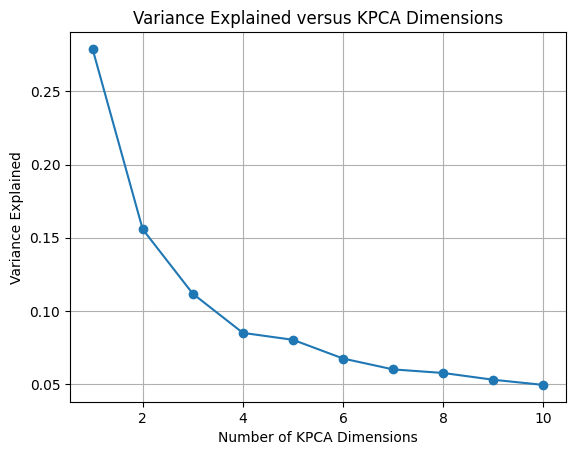

In [19]:
# Compute explained variance for each KPCA dimension
kpca_transform = kpca.fit_transform(features)##transforms to non linear feature space
explained_variance = np.var(kpca_transform, axis=0)##computes the variance of each principal component along axis = 0
explained_variance_ratio = explained_variance / np.sum(explained_variance) ## convert to ratio

# visulaize
plt.plot(range(1, 11), explained_variance_ratio, marker='o') ## vary pdimension from 2 to 11
plt.xlabel('Number of KPCA Dimensions')
plt.ylabel('Variance Explained')
plt.title('Variance Explained versus KPCA Dimensions')
plt.grid(True)
plt.show()

maximum variance stored in starting principal components, owing to dimensional reduction in non linear space , its more suitable for datasets with complex, nonlinear structures, such as images like ours